In [1]:
import parsers
import pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Preparation

In [2]:
pid_oid = pd.read_csv('link.csv')

In [3]:
pid_oid

,patient_id,original_id
0,SCD0000101,SC-HF-I-1
1,SCD0000201,SC-HF-I-2
2,SCD0000301,SC-HF-I-4
3,SCD0000401,SC-HF-I-5
4,SCD0000501,SC-HF-I-6


## Parser API - DICOM Parser

In [4]:
pid = pid_oid['patient_id'][0]
fid = 59

In [5]:
dicom_parser = parsers.DicomParser(pid, fid)
dicom_image = dicom_parser.parse()

In [6]:
print(type(dicom_image))
print(dicom_image.shape)

<type 'numpy.ndarray'>
(256, 256, 3)


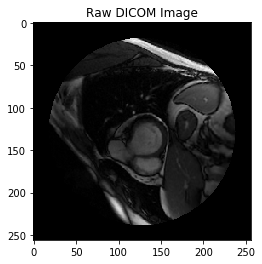

In [7]:
dicom_parser.visualize(dicom_image)

## Parser API - Contour Parser: i-contour and o-contour

In [8]:
oid = pid_oid['original_id'][0]
contour_fid = 59

In [9]:
contour_types = ['i', 'o']
contour_polygons = {}

In [10]:
for contour_type in contour_types:
    print('parsing %s-contour...' % (contour_type))
    contour_parser = parsers.ContourParser(oid, contour_fid, contour_type)
    contour_polygon = contour_parser.parse()
    contour_polygons[contour_type] = contour_polygon
    print 'contour polygon data type: ', type(contour_polygon)
    print '-' * 64

parsing i-contour...
contour polygon data type:  <type 'list'>
----------------------------------------------------------------
parsing o-contour...
contour polygon data type:  <type 'list'>
----------------------------------------------------------------


## Parser API - Boolean Mask Parser: i-contour and o-contour

In [11]:
masks = {}

parsing i-contour mask...
mask data type:  <type 'numpy.ndarray'>
mask shape:  (256, 256, 3)


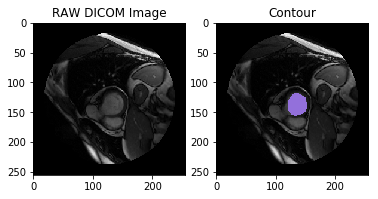

----------------------------------------------------------------
parsing o-contour mask...
mask data type:  <type 'numpy.ndarray'>
mask shape:  (256, 256, 3)


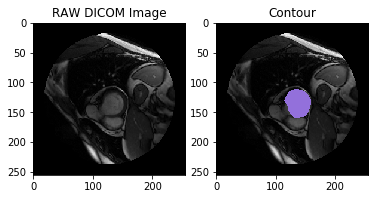

----------------------------------------------------------------


In [12]:
for contour_type in contour_types:
    print('parsing %s-contour mask...' % (contour_type))
    contour_polygon = contour_polygons[contour_type]
    mask_parser = parsers.MaskParser(dicom_image, contour_polygon)
    mask = mask_parser.parse()
    masks[contour_type] = mask
    print 'mask data type: ', type(mask)
    print 'mask shape: ', mask.shape
    mask_parser.visualize()
    print '-' *64

In [13]:
def plot_dicom_imask_omask(dicom, imask, omask):
    dicom_imsk = parsers.combine_dicom_with_mask(dicom, imask)
    dicom_omsk = parsers.combine_dicom_with_mask(dicom, omask)

    plt.subplot(1, 3, 1)
    plt.imshow(dicom)
    plt.title('Raw IDCOM Image')

    plt.subplot(1, 3, 2)
    plt.imshow(dicom_imsk)
    plt.title('I-Contour')

    plt.subplot(1, 3, 3)
    plt.imshow(dicom_omsk)
    plt.title('O-Contour')
    plt.show()

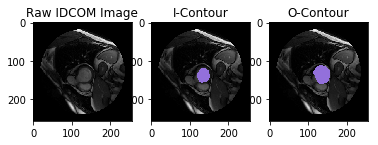

In [14]:
plot_dicom_imask_omask(dicom_image, masks['i'], masks['o'])

## Training Pipeline API
### Loading and matching DICOM images, I-Contours, O-Contours

In [15]:
link_fn = 'link.csv'
batch_size = 8

In [17]:
train_pipe = pipeline.TrainingPipeline(link_fn, batch_size)
print(train_pipe._inputs is None, train_pipe._targets is None)

(True, True)


Preparing training data...


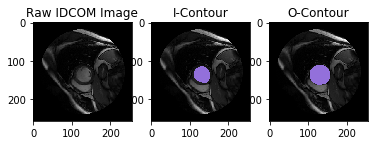

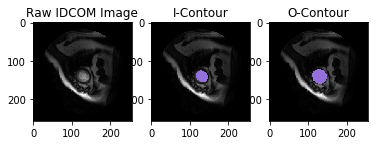

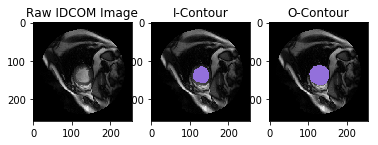

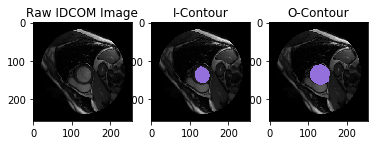

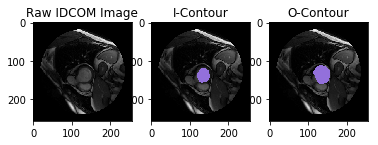

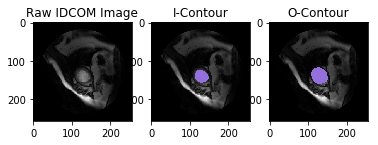

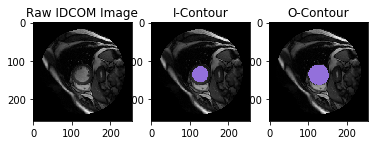

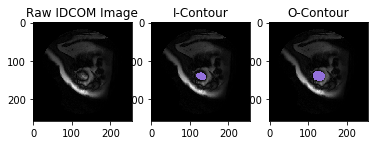

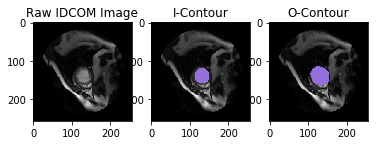

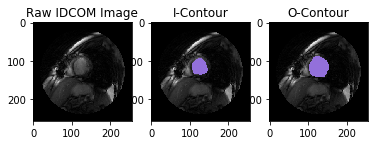

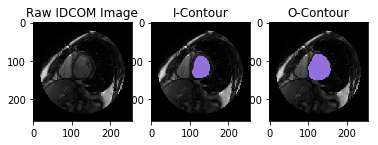

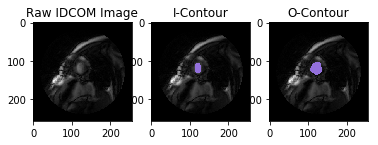

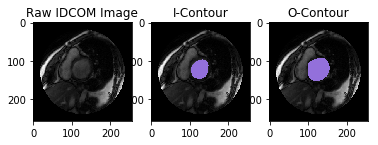

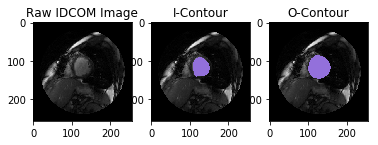

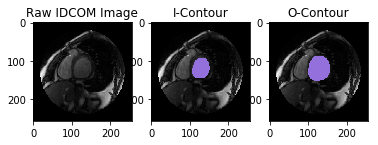

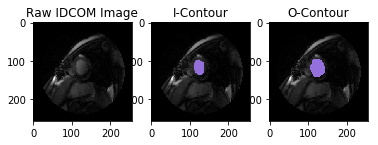

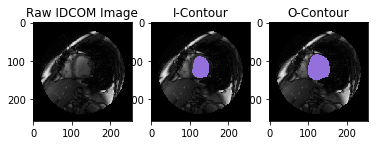

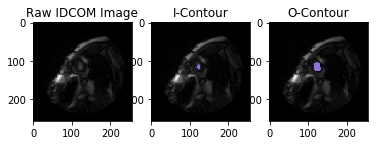

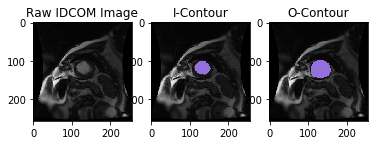

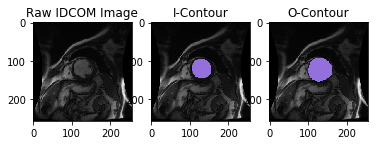

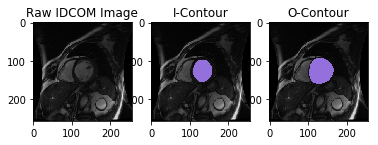

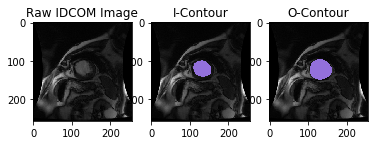

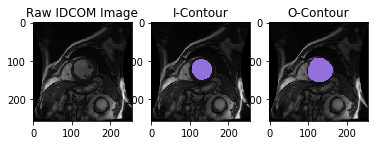

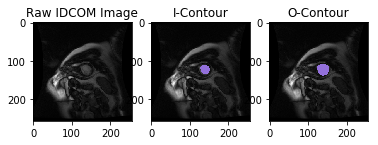

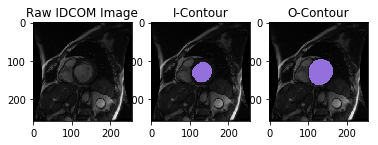

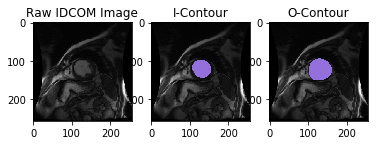

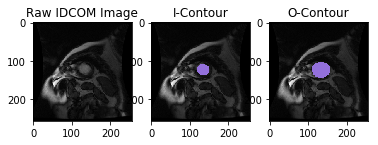

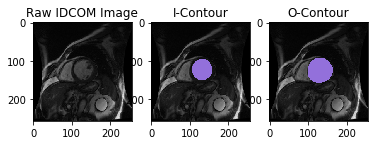

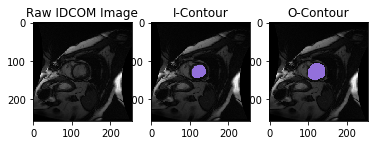

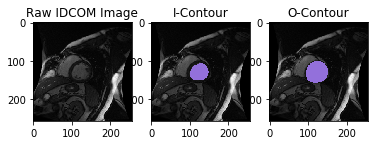

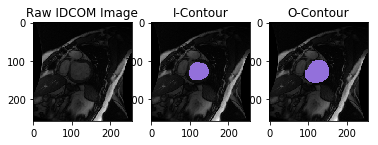

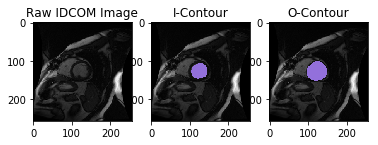

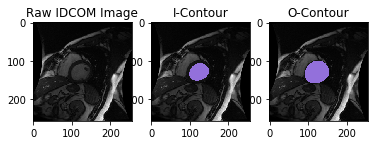

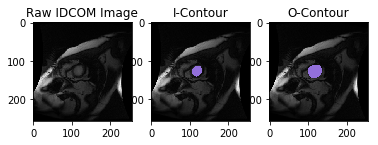

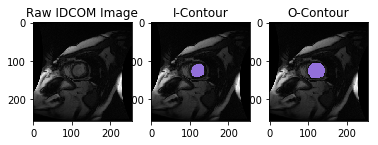

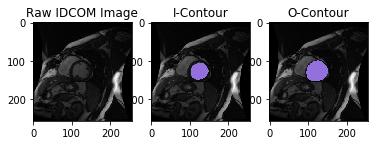

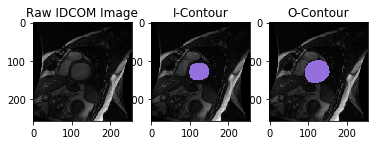

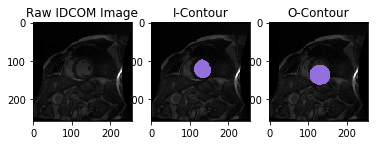

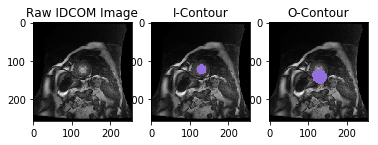

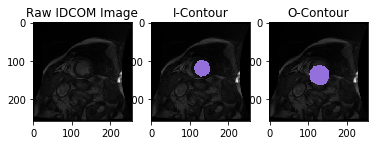

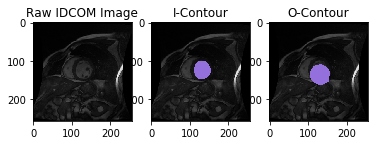

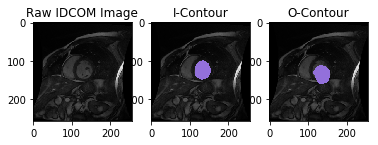

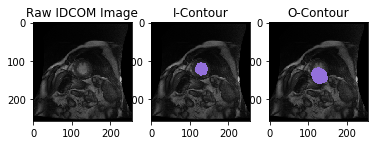

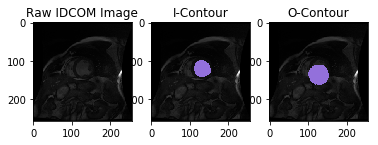

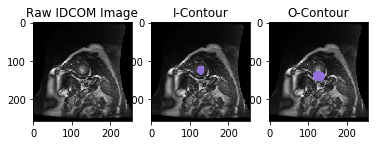

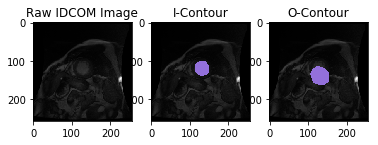

(False, False)


In [18]:
train_pipe.prepare_training_data(True)
print(train_pipe._inputs is None, train_pipe._targets is None)

In [22]:
print('number of inputs: %d\t number of targets: %d' % (len(train_pipe._inputs), len(train_pipe._targets)))
print 'input data shape:\t', train_pipe._inputs.shape
print 'target data shape:\t', train_pipe._targets.shape

number of inputs: 46	 number of targets: 46
input data shape:	(46, 256, 256, 3)
target data shape:	(46, 256, 256, 3, 2)


### Batch Serving `(input, target)` Pairs

In [23]:
num_training_steps = 20
for i in range(num_training_steps):
    batch_input, batch_target = train_pipe.next_batch()
    print('training step: %d \t batch size: %d' %(i, len(batch_input)))

training step: 0 	 batch size: 8
training step: 1 	 batch size: 8
training step: 2 	 batch size: 8
training step: 3 	 batch size: 8
training step: 4 	 batch size: 8
Finished iterating one epoch, reshuffling...
training step: 5 	 batch size: 8
training step: 6 	 batch size: 8
training step: 7 	 batch size: 8
training step: 8 	 batch size: 8
training step: 9 	 batch size: 8
training step: 10 	 batch size: 8
Finished iterating one epoch, reshuffling...
training step: 11 	 batch size: 8
training step: 12 	 batch size: 8
training step: 13 	 batch size: 8
training step: 14 	 batch size: 8
training step: 15 	 batch size: 8
training step: 16 	 batch size: 8
Finished iterating one epoch, reshuffling...
training step: 17 	 batch size: 8
training step: 18 	 batch size: 8
training step: 19 	 batch size: 8


#### Changes made in `parsers.py` and the reasoning of the changes
- Changes in `parsers.DicomParser`
    - Add a `process` step to the `parse` method so that the parsed output is DICOM image in gray scale RGB format
    - Add a `visualize` method to help visualize the processed raw DICOM image
    - These changes not only provide a more well-defined and cleaner API interface for parsing DICOM image but also provide an accessble tool for visualizing data and help debug data quality problem at an early statge.
- Changes in `parsers.MaskParser`
    - Add a step to convert the 2D boolean mask to a 3D boolean mask which matches the parsed DICOM image
    - Fractor out the `combine_dicom_with_mask` method from the `parsers.MaskParser` internally to a global function in `parsers`
    - These changes provide a more well-defined and cleaner API interface for producing boolean mask based on DICOM image and contour files. Additionally, fractoring out the function for overlying boolean mask onto the DICOM image allows this function to be reused in other scope (i.e. in `pipeline.py`) easily.

#### Changes made in `pipeline.py` and the reasoning of the changes
- Remove `contour_type` as constructor input variable and create memeber variable `_contour_types` for storing both the `i-contour` and `o-contour` types.
- The functionality of private method `_get_call_contour_ids` is changed to find sample records which have both `i-contour` data and `o-contour` data
- The private method `_parse_input_output` is changed to first parse both i-contour and o-contour boolean mask and then stack the two types of contour masks in the last dimension to form the `target` output.
- Add a `visualize` parameter to the `prepare_training_data` method to provide a choice of visualizing all the input and target data
- These changes allow `TrainingPipeline` to compactly parse raw DICOM data and two types of contours. Adding the visualization functionality makes it easy to debug and perform qualitative sanity check up on data. 